In [5]:
import sys
sys.path.append("../..")

import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from src.capture.capture import CameraFrameCapture
from src.config.path import SEGMENTATION_MP_PATH

In [6]:
base_options = python.BaseOptions(model_asset_path=SEGMENTATION_MP_PATH)
options = vision.ImageSegmenterOptions(base_options=base_options, output_category_mask=True)
segmenter = vision.ImageSegmenter.create_from_options(options)

In [7]:
DESIRED_HEIGHT = 256
DESIRED_WIDTH = 256

def resize(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  
  return img

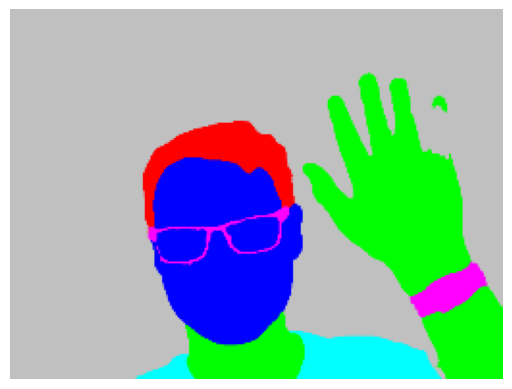

In [8]:
with CameraFrameCapture() as cap:
    frame = cap.read()

    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    image_data = image.numpy_view()

    output_image = np.zeros(image_data.shape, dtype=np.uint8)

    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = (192, 192, 192)

    hair_image = np.zeros(image_data.shape, dtype=np.uint8)
    hair_image[:] = (255, 0, 0)

    body_image = np.zeros(image_data.shape, dtype=np.uint8)
    body_image[:] = (0, 255, 0)

    face_image = np.zeros(image_data.shape, dtype=np.uint8)
    face_image[:] = (0, 0, 255)

    clothes_image = np.zeros(image_data.shape, dtype=np.uint8)
    clothes_image[:] = (0, 255, 255)

    others_image = np.zeros(image_data.shape, dtype=np.uint8)
    others_image[:] = (255, 0, 255)

    bg_condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) == 0
    hair_condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) == 1
    body_condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) == 2
    face_condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) == 3
    clothes_condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) == 4
    others_condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) == 5

    output_image = np.where(bg_condition, bg_image, output_image)
    output_image = np.where(hair_condition, hair_image, output_image)
    output_image = np.where(body_condition, body_image, output_image)
    output_image = np.where(face_condition, face_image, output_image)
    output_image = np.where(clothes_condition, clothes_image, output_image)
    output_image = np.where(others_condition, others_image, output_image)


    output_image = resize(output_image)

    plt.imshow(output_image)
    plt.axis('off')
    plt.show()